In [1]:
# %matplotlib inline
# %load_ext autotime
# %config InlineBackend.figure_format = 'retina'

time: 20.2 ms


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as pt
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats
import sklearn as sk
import sklearn.model_selection
import sklearn.preprocessing

time: 1.91 s


In [3]:
import keras
import tensorflow as tf

Using TensorFlow backend.
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


time: 3.66 s


In [96]:
import collections

time: 5.77 ms


In [4]:
mpl.rcParams[ 'figure.figsize' ] = ( 18, 3 )
pd.set_option( 'display.max_columns', 200 )

time: 3.82 ms


In [190]:
# envname = 'Humanoid-v1'
# envname = 'Ant-v1'
# envname = 'Hopper-v1'
# envname = 'HalfCheetah-v1'
envname = 'Reacher-v1'
# envname = 'Walker2d-v1'

time: 1.61 ms


In [191]:
with open( 'data/%s-data.csv' % envname, 'rb' ) as f:
    d = pickle.load( f )

time: 77.9 ms


In [192]:
x = d[ 'observations' ]
y = np.squeeze( d[ 'actions' ], 1 )
x.shape, y.shape

((10000, 11), (10000, 2))

time: 14.2 s


In [193]:
x_dim = x.shape[ 1 ]
y_dim = y.shape[ 1 ]

time: 7.11 ms


In [194]:
train_x, val_x, train_y, val_y = sk.model_selection.train_test_split( x, y )
( train_x.shape, train_y.shape ), ( val_x.shape, val_y.shape )

(((7500, 11), (7500, 2)), ((2500, 11), (2500, 2)))

time: 665 ms


In [195]:
scaler = sk.preprocessing.StandardScaler()
scaler.fit( train_x )
train_x = scaler.transform( train_x )
val_x = scaler.transform( val_x )

time: 24.5 ms


In [259]:
hidden_dim = 64
batch_size = 1024 * 256

m_in = keras.layers.Input( shape=( x_dim, ) )
m_outs = [ keras.layers.Dense( 1, kernel_initializer='glorot_normal' )( keras.layers.Activation( 'tanh' )( keras.layers.BatchNormalization()( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' )( m_in ) ) ) ) for _ in range( y_dim ) ]
m_out = keras.layers.Concatenate()( m_outs )
m = keras.models.Model( inputs=m_in, outputs=m_out )
m.compile( optimizer='adam', loss='mse' )

print( 'training with Adam ...' )
cbs = [ keras.callbacks.EarlyStopping( min_delta=0, patience=10 ) ]
h1 = m.fit( train_x,train_y, batch_size=batch_size, epochs=5000, verbose=0, callbacks=cbs, validation_data=( val_x, val_y ) )
print( '\tfinished (%i epochs)' % len( h1.history[ 'loss' ] ) )
m.compile( optimizer='SGD', loss='mse' )
print( 'training with SGD ...' )
cbs = [ keras.callbacks.EarlyStopping( min_delta=0, patience=10 ) ]
if envname == 'Reacher-v1':
    h2 = m.fit( train_x,train_y, batch_size=batch_size, epochs=500000, verbose=0, callbacks=cbs, validation_data=( val_x, val_y ) )
else: 
    h2 = m.fit( train_x,train_y, batch_size=batch_size, epochs=5000, verbose=0, callbacks=cbs, validation_data=( val_x, val_y ) )
print( '\tfinished (%i epochs)' % len( h2.history[ 'loss' ] ) )
p = m.predict( train_x, batch_size=batch_size )

m.save( 'nn-model/%s-nn.h5' % envname )

training with Adam ...
	finished (37 epochs)
training with SGD ...
	finished (500000 epochs)
time: 5h 15min 55s


0.0256510730833 6.23893211014e-05


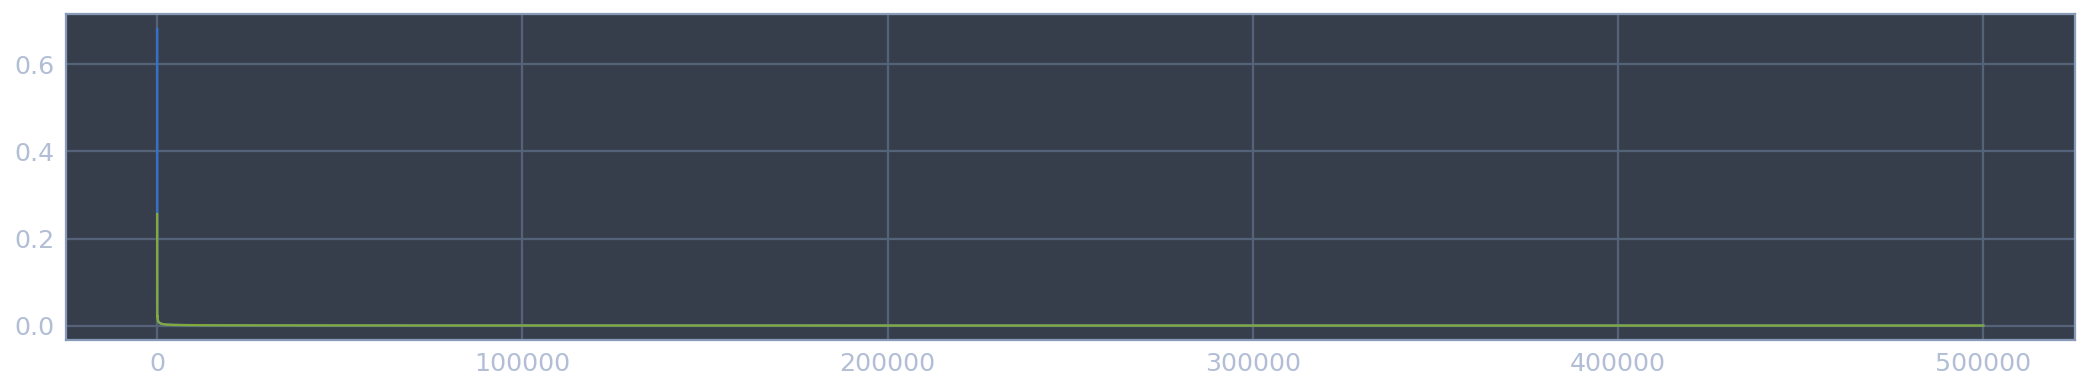

time: 2.62 s


In [261]:
print( h1.history[ 'loss' ][ -1 ], h2.history[ 'loss' ][ -1 ] )
pd.Series( h1.history[ 'loss' ] + h2.history[ 'loss' ] ).plot();
pd.Series( h1.history[ 'val_loss' ] + h2.history[ 'val_loss' ] ).plot();

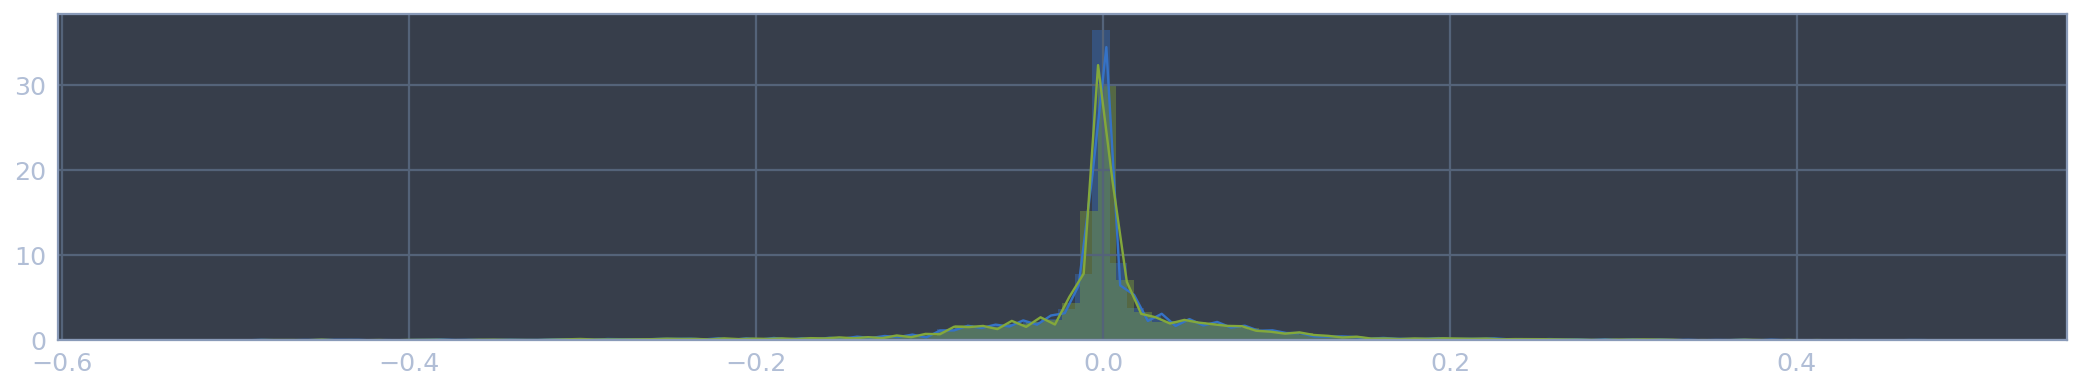

time: 628 ms


In [262]:
sns.distplot( train_y[ :, 0 ], bins=100 );
sns.distplot( p[ :, 0 ], bins=100 );

In [263]:
scipy.stats.ks_2samp( y[ :, 0 ], p[ :, 0 ] )

Ks_2sampResult(statistic=0.021633333333333338, pvalue=0.03567794580475811)

time: 11.6 ms


In [264]:
train_y[ :, 0 ][ : 20 ]

array([ -8.39531273e-02,  -2.40558535e-02,  -9.35748313e-03,
        -1.16729271e-03,  -5.18351514e-03,   4.87446133e-03,
         1.47789437e-03,  -2.13939548e-02,  -1.57566741e-04,
        -6.06219284e-04,  -5.23534358e-01,  -1.34228449e-03,
         1.91837642e-03,   5.73472399e-03,  -4.25701123e-03,
        -2.39890926e-02,   7.56727532e-05,   2.44477801e-02,
        -7.35413563e-03,  -2.00018287e-04], dtype=float32)

time: 3.87 ms


In [265]:
p[ : 20 ][ :, 0 ]

array([ -7.92235956e-02,  -2.30709091e-02,  -6.18323404e-03,
        -6.10747375e-04,  -9.74977855e-03,   2.49955710e-03,
         2.04766449e-03,  -1.76571086e-02,   1.02045294e-03,
         4.37451061e-03,  -5.40269494e-01,   1.51837524e-03,
        -8.95165838e-04,   6.26031216e-03,  -1.69652048e-03,
        -3.15027311e-02,  -1.84201077e-02,   2.31561735e-02,
        -4.68404032e-04,  -1.93054322e-03], dtype=float32)

time: 12.3 ms
